# Segmenting and clustering Neighborhoods in Toronto
### Peer-graded assignment
### Week 3

In this assignment we are required to explore, segment and cluster the neighborhoods in the city of Toronto.
The data will be acquired by scraping, wrangling and cleaning it from a Wikipedia page.
After the data will be structured, the dataset/pandas dataframe will be analysed to explore and cluster the neighborhoods. Finally, the submission will be a link to the notebook on the Github repository.

## 1. Setting up the environment and extracting data

## This(different method than the one provided by the instructor) is the easiest way to do it:you can read a HTML into a list of Dataframe objects with Pandas read_html(). It finds the HTML table, does the parsing and creates the df!

In [1]:
!pip install wikipedia

  Running setup.py bdist_wheel for wikipedia ... done
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/87/2a/18/4e471fd96d12114d16fe4a446d00c3b38fb9efcb744bd31f4a
Successfully built wikipedia
distributed 1.21.8 requires msgpack, which is not installed.


In [2]:
import pandas as pd
import wikipedia as wp

In [3]:
html = wp.page("List of postal codes of Canada: M").html().encode("UTF-8")
df = pd.read_html(html)[0]
df.to_csv('beautifulsoup_pandas.csv', header=0, index=False)
df.head()


,0,1,2
0,Postcode,Borough,Neighbourhood
1,M1A,Not assigned,Not assigned
2,M2A,Not assigned,Not assigned
3,M3A,North York,Parkwoods
4,M4A,North York,Victoria Village


In [4]:
# Set the column labels to equal the values in the 1st row (index location 0)
df.columns = df.iloc[0]
df.head()

,Postcode,Borough,Neighbourhood
0,Postcode,Borough,Neighbourhood
1,M1A,Not assigned,Not assigned
2,M2A,Not assigned,Not assigned
3,M3A,North York,Parkwoods
4,M4A,North York,Victoria Village


In [5]:
# drop the first row
df1 = df.reindex(df.index.drop(0))
df1.head()

,Postcode,Borough,Neighbourhood
1,M1A,Not assigned,Not assigned
2,M2A,Not assigned,Not assigned
3,M3A,North York,Parkwoods
4,M4A,North York,Victoria Village
5,M5A,Downtown Toronto,Harbourfront


In [6]:
# change the name of the first column to PostalCode and the 3rd to Neighborhood
df1.rename(columns={'Postcode':'PostalCode', 'Neighbourhood':'Neighborhood'}, inplace=True)
df1.head()

,PostalCode,Borough,Neighborhood
1,M1A,Not assigned,Not assigned
2,M2A,Not assigned,Not assigned
3,M3A,North York,Parkwoods
4,M4A,North York,Victoria Village
5,M5A,Downtown Toronto,Harbourfront


In [7]:
df1.shape

(289, 3)

## 2. Now that we have our DataFrame we can do some cleaning.

In [20]:
# as we shall analyse only cells that have an assigned borough we drop the rows that have 'Not assigned' in Borough
df2 = df1[df1.Borough != 'Not assigned']
df2 = df2.sort_values(by=['PostalCode', 'Borough'])

df2.reset_index(inplace=True)
df2.drop('index', axis=1, inplace=True)
df2.head()

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,Rouge
1,M1B,Scarborough,Malvern
2,M1C,Scarborough,Highland Creek
3,M1C,Scarborough,Rouge Hill
4,M1C,Scarborough,Port Union


##### We're almost there, but we have to do something about multiple neighborhoods with the same postal code. These neighborhoods need to be combined in one row and be separated by a comma. If a cell has a borough but a 'Not  assigned' neighborhood, then the neighborhood will be the same as the borough, therefore we need to continue to clean up our DataFrame.

In [10]:
df_postalcodes = df2['PostalCode']
df_postalcodes.drop_duplicates(inplace=True)
df3 = pd.DataFrame(df_postalcodes)
df3['Borough'] = '';
df3['Neighborhood'] = '';
df3.reset_index(inplace=True)
df3.drop('index', axis=1, inplace=True)
df2.reset_index(inplace=True)
df2.drop('index', axis=1, inplace=True)

for i in df3.index:
    for j in df2.index:
        if df3.iloc[i, 0]==df2.iloc[j, 0]:
            df3.iloc[i, 1] = df2.iloc[j, 1]
            df3.iloc[i, 2] = df3.iloc[i, 2] + ',' +df2.iloc[j, 2]
            
for i in df3.index:
    s = df3.iloc[i, 2]
    if s[0] ==',':
        s = s [1:]
    df3.iloc[i, 2] = s
    
df3.shape

(103, 3)

#### Let's give this final df a more relevant name as we'll work with it later on.

In [17]:
df_Toronto = df3
df_Toronto.head(12)

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge,Malvern"
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union"
2,M1E,Scarborough,"Guildwood,Morningside,West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
5,M1J,Scarborough,Scarborough Village
6,M1K,Scarborough,"East Birchmount Park,Ionview,Kennedy Park"
7,M1L,Scarborough,"Clairlea,Golden Mile,Oakridge"
8,M1M,Scarborough,"Cliffcrest,Cliffside,Scarborough Village West"
9,M1N,Scarborough,"Birch Cliff,Cliffside West"


#### Let's take a look at the distibution of Neighborhoods by Borough

In [13]:
import matplotlib.pyplot as plt

<function matplotlib.pyplot.show(*args, **kw)>

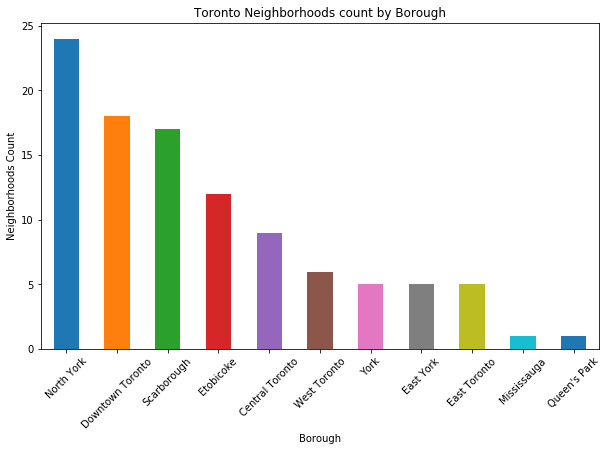

In [16]:
df_Toronto['Borough'].value_counts().plot(kind='bar', figsize=(10, 6), rot=45)
plt.xlabel('Borough')
plt.ylabel('Neighborhoods Count')
title= 'Toronto Neighborhoods count by Borough'
plt.title(title)
plt.savefig('Toronto_Neighborhoods_by_Borough.png')
plt.show

# Get Geo-data

In [35]:
geo_df = pd.read_csv("http://cocl.us/Geospatial_data")
geo_df.columns=["PostalCode", "Latitude", "Longitude"]
geo_df.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [39]:
df = pd.merge(df_Toronto, geo_df, on='PostalCode')
df.head(12)

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
6,M1K,Scarborough,"East Birchmount Park,Ionview,Kennedy Park",43.727929,-79.262029
7,M1L,Scarborough,"Clairlea,Golden Mile,Oakridge",43.711112,-79.284577
8,M1M,Scarborough,"Cliffcrest,Cliffside,Scarborough Village West",43.716316,-79.239476
9,M1N,Scarborough,"Birch Cliff,Cliffside West",43.692657,-79.264848


## Create a map of Toronto with neighborhoods superimposed on top

In [28]:
# import folium to create map
!conda install -c conda-forge folium=0.5.0 --yes
import folium

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.0.2p             |       h470a237_1         3.1 MB  conda-forge
    certifi-2018.10.15         |        py36_1000         138 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    branca-0.3.0               |             py_0          24 KB  conda-forge
    ca-certificates-2018.10.15 |       ha4d7672_0         135 KB  conda-forge
    conda-4.5.11               |        py36_1000         651 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    altair-2.2.2               |        py36_1001         494 KB  conda-forge
    ------------------------------------------------------------
                         

In [43]:
map_toronto = folium.Map(location=[43.777702,-79.233238], zoom_start=10)
# add markers to map
for lat, lng, borough, neighborhood in zip(df['Latitude'],
                                          df['Longitude'],
                                          df['Borough'],
                                          df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
    [lat, lng],
    radius=5, 
    popup=label,
    color='red',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.7,
    parse_html=False).add_to(map_toronto)
map_toronto